# Masks and Filters
>  Cut image processing to the bone by transforming x-ray images. You'll learn how to exploit intensity patterns to select sub-regions of an array, and you'll use convolutional filters to detect interesting features. You'll also use SciPy's ndimage module, which contains a treasure trove of image processing tools.

- toc: true 
- badges: true
- comments: true
- author: Lucas Nunes
- categories: [Datacamp]
- image: images/datacamp/___

> Note: This is a summary of the course's chapter 2 exercises "Biomedical Image Analysis in Python" at datacamp. <br>[Github repo](https://github.com/lnunesAI/Datacamp/) / [Course link](https://www.datacamp.com/tracks/machine-learning-scientist-with-python)

In [37]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8, 8)

## Image intensities

### Intensity

<div class=""><p>In this chapter, we will work with a hand <a href="https://en.wikipedia.org/wiki/Radiography" target="_blank" rel="noopener noreferrer">radiograph</a> from a 2017 <a href="http://rsnachallenges.cloudapp.net/competitions/4" target="_blank" rel="noopener noreferrer">Radiological Society of North America competition</a>. X-ray absorption is highest in dense tissue such as bone, so the resulting intensities should be high. Consequently, images like this can be used to predict "bone age" in children.</p>
<p>To start, let's load the image and check its intensity range. </p>
<p>The image datatype determines the range of possible intensities: e.g., 8-bit unsigned integers (<code>uint8</code>) can take values in the range of 0 to 255. A colorbar can be helpful for connecting these values to the visualized image.</p>
<p>All exercises in this chapter have the following imports:</p>
<pre><code>import imageio
import numpy as np
import matplotlib.pyplot as plt
</code></pre></div>

In [26]:
%%capture
!wget https://github.com/lnunesAI/Datacamp/raw/main/3-skill-tracks/biomedical-image-analysis-in-python/data/hand-xray.jpg

In [29]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    fig.axes[0].axis('off')
    plt.tight_layout()
    plt.show()

Instructions
<ul>
<li>Load the image "hand-xray.jpg" using <code>imageio</code>.</li>
<li>Print the image's data type (<code>dtype</code>), minimum (<code>min()</code>) and maximum intensity (<code>max()</code>).</li>
<li>Plot the image using <code>plt.imshow()</code>. Explicitly set the colormap's minimum (<code>0</code>) and maximum (<code>255</code>) values using the <code>vmin</code> and <code>vmax</code> arguments. </li>
<li>Add a colorbar using <code>plt.colorbar()</code>, then render the plot using the custom function <code>format_and_render_plot()</code>. This has been done for you.</li>
</ul>

Data type: uint8
Min. value: 0
Max value: 255


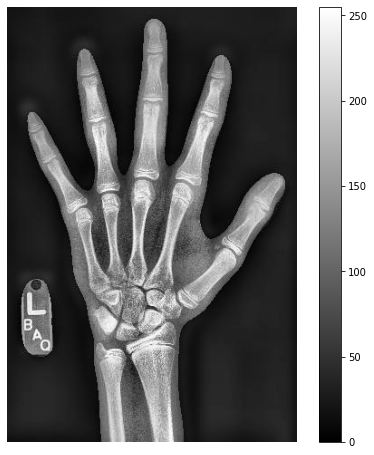

In [119]:
# Load the hand radiograph
im = imageio.imread("hand-xray.jpg")
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

# Plot the grayscale image
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
format_and_render_plot()

**Although only a coarse descriptor, the range of intensities can help you get a quick feel for your image's content.**

### Histograms

<div class=""><p><strong>Histograms</strong> display the distribution of values in your image by binning each element by its intensity then measuring the size of each bin. </p>
<p>The area under a histogram is called the <strong>cumulative distribution function</strong>. It measures the frequency with which a given range of pixel intensities occurs.</p>
<p>For this exercise, describe the intensity distribution in <code>im</code> by calculating the histogram and cumulative distribution function and displaying them together.</p></div>

In [31]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.legend(loc='center right')
    plt.show()

Instructions
<ul>
<li>Import <code>scipy.ndimage</code> as <code>ndi</code>.</li>
<li>Generate a 256-bin histogram of <code>im</code> which covers the full range of <code>np.uint8</code> values.</li>
<li>Calculate the cumulative distribution function for <code>im</code>. First, find the cumulative sum of <code>hist</code>, then divide by the total number of pixels in <code>hist</code>.</li>
<li>Plot <code>hist</code> and <code>cdf</code> on separate subplots. This has been done for you.</li>
</ul>

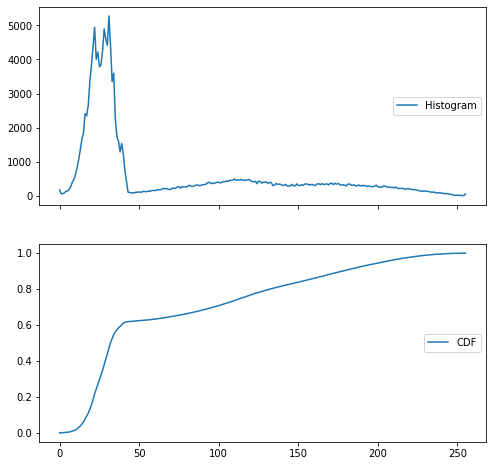

In [32]:
# Import SciPy's "ndimage" module
import scipy.ndimage as ndi 

# Create a histogram, binned at each possible value
hist = ndi.histogram(im, min=0, max=255, bins=256)

# Create a cumulative distribution function
cdf = hist.cumsum() / hist.sum()

# Plot the histogram and CDF
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(hist, label='Histogram')
axes[1].plot(cdf, label='CDF')
format_and_render_plot()

**You can see the data is clumped into a few separate distributions, consisting of background noise, skin, bone, and artifacts. Sometimes we can separate these well with global thresholds (foreground/background); other times the distributions overlap quite a bit (skin/bone).**

## Masks

### Create a mask

<div class=""><p><strong>Masks</strong> are the primary method for removing or selecting specific parts of an image. They are binary arrays that indicate whether a value should be included in an analysis. Typically,  masks are created by applying one or more logical operations to an image. </p>
<p>For this exercise, try to use a simple intensity threshold to differentiate between skin and bone in the hand radiograph. (<code>im</code> has been equalized to utilize the whole intensity range.)</p>
<p>Below is the histogram of <code>im</code> colored by the segments we will plot.</p>
<p>
  <img src="https://assets.datacamp.com/production/repositories/2085/datasets/2ab92b62dcda199dd6496f26ab72991988a5d94b/Ch2_L2_EqHist.png" alt="Histogram of equalized foot x-ray" width="40%">
</p></div>

In [33]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

Instructions
<ul>
<li>Create a bone mask by selecting pixels with intensities greater than or equal to <code>145</code>. </li>
<li>Create a skin mask by selecting pixels with intensities greater than or equal to <code>45</code> and less than <code>145</code>.</li>
<li>Plot the skin and bone masks in grayscale.</li>
</ul>

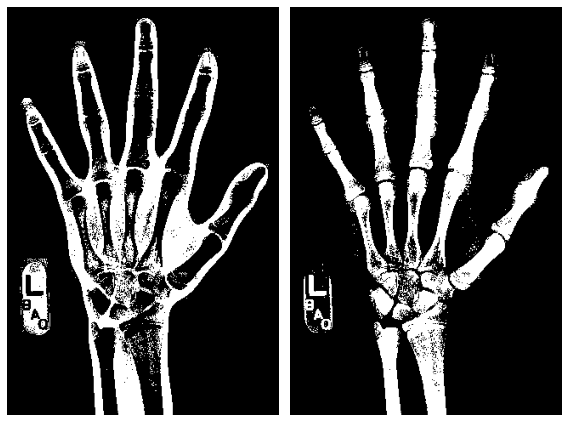

In [34]:
# Create skin and bone masks
mask_bone = im >= 145
mask_skin = (im >= 45) & (im < 145)

# Plot the skin (0) and bone (1) masks
fig, axes = plt.subplots(1,2)
axes[0].imshow(mask_skin, cmap='gray')
axes[1].imshow(mask_bone, cmap='gray')
format_and_render_plot()

**You can chain logic together to make some quite complex masks.**

### Apply a mask

<div class=""><p>Although masks are binary, they can be <em>applied</em> to images to filter out pixels where the mask is <code>False</code>.</p>
<p>NumPy's <code>where()</code> function is a flexible way of applying masks. It takes three arguments:</p>
<pre><code>np.where(condition, x, y)
</code></pre>
<p><code>condition</code>, <code>x</code> and <code>y</code> can be either arrays or single values. This allows you to pass through original image values while setting masked values to 0.</p>
<p>Let's practice applying masks by selecting the bone-like pixels from the hand x-ray (<code>im</code>).</p></div>

In [36]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    fig.axes[0].axis('off')   
    plt.tight_layout()
    plt.show()

Instructions
<ul>
<li>Create a Boolean bone mask by selecting pixels greater than or equal to 145. </li>
<li>Apply the mask to your image using <code>np.where()</code>. Values not in the mask should be set to <code>0</code>.</li>
<li>Create a histogram of the masked image. Use the following arguments to select only non-zero pixels: <code>min=1</code>, <code>max=255</code>, <code>bins=255</code>. </li>
<li>Plot the masked image and the histogram. This has been done for you.</li>
</ul>

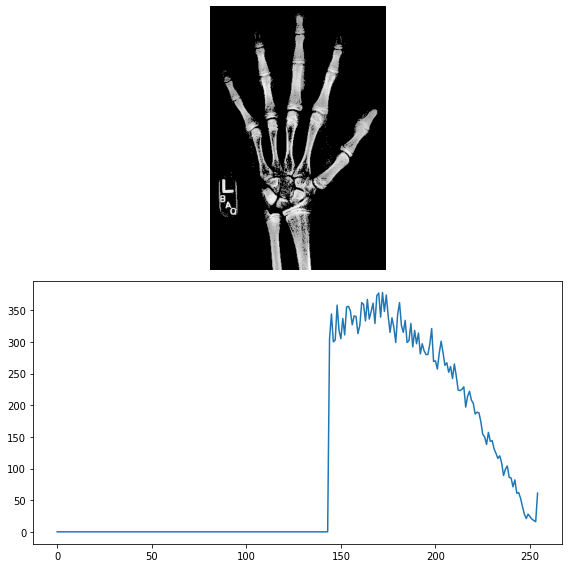

In [40]:
# Import SciPy's "ndimage" module
import scipy.ndimage as ndi 

# Screen out non-bone pixels from "im"
mask_bone = im >= 145
im_bone = np.where(mask_bone, im, 0)

# Get the histogram of bone intensities
hist = ndi.histogram(im_bone, min=1, max=255, bins=255)

# Plot masked image and histogram
fig, axes = plt.subplots(2,1)
axes[0].imshow(im_bone, cmap='gray')
axes[1].plot(hist)
format_and_render_plot()

**Sometimes simpler methods for applying a mask such as multiplication (e.g., im * mask_bone) will meet your needs, but np.where() is an excellent tool to have in your arsenal.**

### Tune a mask

<div class=""><p>Imperfect masks can be tuned through the addition and subtraction of pixels. SciPy includes several useful methods for accomplishing these ends. These include: </p>
<ul>
<li><code>binary_dilation</code>: Add pixels along edges</li>
<li><code>binary_erosion</code>: Remove pixels along edges</li>
<li><code>binary_opening</code>: Erode then dilate, "opening" areas near edges</li>
<li><code>binary_closing</code>: Dilate then erode, "filling in" holes</li>
</ul>
<p>For this exercise, create a bone mask then tune it to include additional pixels.</p>
<p>For the remaining exercises, we have run the following import for you: </p>
<pre><code>import scipy.ndimage as ndi
</code></pre></div>

In [49]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Instructions
<ul>
<li>Create a bone by selecting pixels from <code>im</code> that are greater than or equal to <code>145</code>.</li>
<li>Use <code>ndi.binary_dilation()</code> to increase the size of <code>mask_bone</code>. Set the number of <code>iterations</code> to <code>5</code> to perform the dilation multiple times. </li>
<li>Use <code>ndi.binary_closing()</code> to fill in holes in <code>mask_bone</code>. Set the number of <code>iterations</code> to <code>5</code> to holes up to 10 pixels wide. </li>
<li>Plot the original and tuned masks.</li>
</ul>

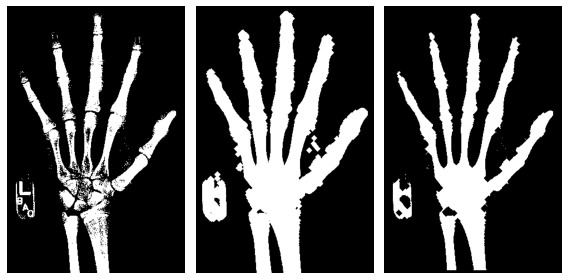

In [50]:
# Create and tune bone mask
mask_bone = im >= 145
mask_dilate = ndi.binary_dilation(mask_bone, iterations=5)
mask_closed = ndi.binary_closing(mask_bone, iterations=5)

# Plot masked images
fig, axes = plt.subplots(1,3)
axes[0].imshow(mask_bone, cmap='gray')
axes[1].imshow(mask_dilate, cmap='gray')
axes[2].imshow(mask_closed, cmap='gray')
format_and_render_plot()

**Dilation, erosion, and closing are useful techniques when you want to fine-tune your masks.**

## Filters

<div class=""><p><em>Filters</em> are an essential tool in image processing. They allow you to transform images based on intensity values surrounding a pixel, rather than globally.</p>
<p>
  <img src="https://assets.datacamp.com/production/repositories/2085/datasets/2abe93cb1c040ccc265be7f36db36eb163d91c58/Ch2_L3_ConvolutionGif.gif" alt="2D array convolution. By Michael Plotke [CC BY-SA 3.0  (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons" width="45%">
</p>
<p>For this exercise, smooth the foot radiograph. First, specify the weights to be used. (These are called "footprints" and "kernels" as well.) Then, convolve the filter with <code>im</code> and plot the result.</p></div>

In [47]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Instructions 1/3
<p>Create a three by three array of filter weights. Set each element to <code>0.11</code> to perform mean filtering (also called "uniform filtering").</p>

In [43]:
# Set filter weights
weights = [[0.11, 0.11, 0.11],
           [0.11, 0.11, 0.11], 
            [0.11,  0.11, 0.11]]

Instructions 2/3
<p>Convolve <code>im</code> with <code>weights</code> using <code>ndi.convolve()</code>.</p>

In [44]:
# Convolve the image with the filter
im_filt = ndi.convolve(im, weights)

Instructions 3/3
<p>Plot the original and mean-filtered images.</p>

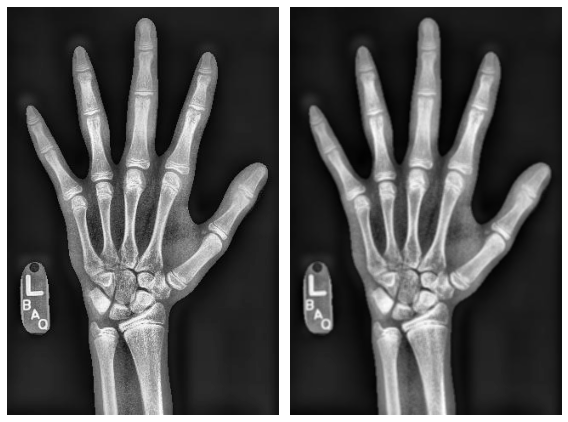

In [48]:
# Plot the images
fig, axes = plt.subplots(1,2)
axes[0].imshow(im, cmap='gray')
axes[1].imshow(im_filt, cmap='gray')
format_and_render_plot()

**The size and pattern of the filter weights control the effect it will have on your image.**

### Filter functions

<div class=""><p>Convolutions rely on a set of weights, but filtering can also be done using functions such as the mean, median and maximum. Just like with convolutions, filter functions will update each pixel value based on its local neighborhood.</p>
<p>Consider the following lines of code: </p>
<pre><code>im = np.array([[93, 36,  87], 
               [18, 49,  51],
               [45, 32,  63]])

im_filt = ____

assert im_filt[1,1] == 49
</code></pre>
<p>Which of the following statements should go in the blank so that the <code>assert</code> statement evaluates to <code>True</code>?</p></div>

<pre>
Possible Answers
ndi.maximum_filter(im, size=3)
ndi.uniform_filter(im, size=3)
ndi.percentile_filter(im, 60, size=3)
<b>ndi.median_filter(im, size=3)</b>
</pre>

**The median filter will return the median value of the 3x3 neighborhood. Note that the values on the edges will vary based on the mode setting of your filter.**

### Smoothing

<div class=""><p>Smoothing can improve the <a href="https://en.wikipedia.org/wiki/Signal-to-noise_ratio" target="_blank" rel="noopener noreferrer"><strong>signal-to-noise ratio</strong></a> of your image by blurring out small variations in intensity. The Gaussian filter is excellent for this: it is a circular (or spherical) smoothing kernel that weights nearby pixels higher than distant ones.</p>
<p>
  <img src="https://assets.datacamp.com/production/repositories/2085/datasets/f5c784ab505d261728f7a3eb40225e87d4526c9f/Ch2_L2_Gaussian1D.png" width="30%">
</p>
<p>The width of the distribution is controlled by the <code>sigma</code> argument, with higher values leading to larger smoothing effects.</p>
<p>For this exercise, test the effects of applying Gaussian filters to the foot x-ray before creating a bone mask.</p></div>

Instructions
<ul>
<li>Convolve <code>im</code> with Gaussian filters of size <code>sigma=1</code> and <code>sigma=3</code>.</li>
<li>Plot the "bone masks" of <code>im</code>, <code>im_s1</code>, and <code>im_s3</code> (i.e., where intensities are greater than or equal to <code>145</code>).</li>
</ul>

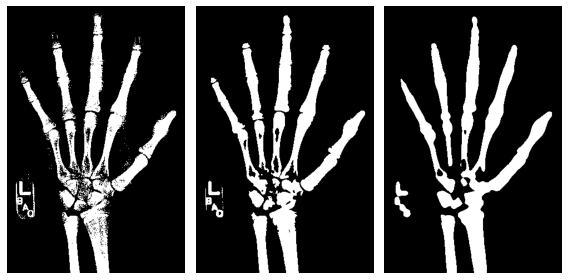

In [52]:
# Smooth "im" with Gaussian filters
im_s1 = ndi.gaussian_filter(im, sigma=1)
im_s3 = ndi.gaussian_filter(im, sigma=3)

# Draw bone masks of each image
fig, axes = plt.subplots(1,3)
axes[0].imshow(im >= 145, cmap="gray")
axes[1].imshow(im_s1 >= 145, cmap="gray")
axes[2].imshow(im_s3 >= 145, cmap="gray")
format_and_render_plot()

**Many analyses can benefit from an initial smoothing of the data.**

## Feature detection

### Detect edges (1)

<div class=""><p>Filters can also be used as "detectors." If a part of the image fits the weighting pattern, the returned value will be very high (or very low). </p>
<p>In the case of edge detection, that pattern is a change in intensity along a plane. A filter detecting horizontal edges might look like this:</p>
<pre><code>weights = [[+1, +1, +1],
           [ 0,  0,  0],
           [-1, -1, -1]]
</code></pre>
<p>For this exercise, create a <strong>vertical</strong> edge detector and see how well it performs on the hand x-ray (<code>im</code>).</p></div>

In [120]:
%%capture 
!wget https://github.com/lnunesAI/Datacamp/raw/main/3-skill-tracks/biomedical-image-analysis-in-python/data/hand-xray_2.jpg
im = imageio.imread('hand-xray_2.jpg')
im = im.astype('float64')

In [78]:
def format_and_render_plot():
    'Custom function to simplify common formatting operations for exercises.'
    fig = plt.gcf()
    fig.axes[0].axis('off')
    plt.show()

Instructions
<ul>
<li>Create a 3x3 array of filter weights that detects when intensity changes from the left to right. Use only the values <code>1</code>, <code>0</code> and <code>-1</code>.</li>
<li>Convolve <code>im</code> with the edge detector. </li>
<li>Plot the horizontal edges with the <code>seismic</code> colormap. Use <code>vmin=-150</code> and <code>vmax=150</code> to control adjust your colormap scale.</li>
<li>Add a colorbar and render the results.</li>
</ul>

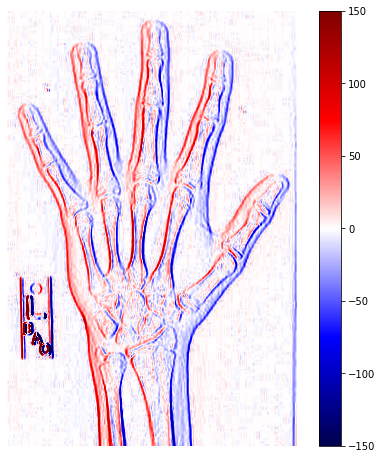

In [121]:
# Set weights to detect vertical edges
weights = [[1, 0, -1], [1, 0, -1], [1, 0, -1]]


# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
plt.imshow(edges, cmap="seismic", vmin=-150, vmax=150)
plt.colorbar()
format_and_render_plot()

**Take a close look at where the edges are - and are not - highlighted to reinforce your understanding of how this detector works.**

## Detect edges (2)

<div class=""><p>Edge detection can be performed along multiple axes, then combined into a single edge value. For 2D images, the horizontal and vertical "edge maps" can be combined using the Pythagorean theorem: </p>
<p><mjx-container class="MathJax CtxtMenu_Attached_0" jax="CHTML" display="true" role="presentation" tabindex="0" ctxtmenu_counter="1" style="font-size: 116.7%; position: relative;"><mjx-math display="true" class="MJX-TEX" aria-hidden="true" style="margin-left: 0px; margin-right: 0px;"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D467 TEX-I"></mjx-c></mjx-mi><mjx-mo class="mjx-n" space="4"><mjx-c class="mjx-c3D"></mjx-c></mjx-mo><mjx-msqrt space="4"><mjx-sqrt><mjx-surd><mjx-mo class="mjx-sop"><mjx-c class="mjx-c221A TEX-S1"></mjx-c></mjx-mo></mjx-surd><mjx-box style="padding-top: 0.173em;"><mjx-msup><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D465 TEX-I"></mjx-c></mjx-mi><mjx-script style="vertical-align: 0.289em;"><mjx-mn class="mjx-n" size="s"><mjx-c class="mjx-c32"></mjx-c></mjx-mn></mjx-script></mjx-msup><mjx-mo class="mjx-n" space="3"><mjx-c class="mjx-c2B"></mjx-c></mjx-mo><mjx-msup space="3"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D466 TEX-I"></mjx-c></mjx-mi><mjx-script style="vertical-align: 0.289em;"><mjx-mn class="mjx-n" size="s"><mjx-c class="mjx-c32"></mjx-c></mjx-mn></mjx-script></mjx-msup></mjx-box></mjx-sqrt></mjx-msqrt></mjx-math><mjx-assistive-mml role="presentation" unselectable="on" display="block"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>z</mi><mo>=</mo><msqrt><msup><mi>x</mi><mn>2</mn></msup><mo>+</mo><msup><mi>y</mi><mn>2</mn></msup></msqrt></math></mjx-assistive-mml></mjx-container></p>
<p>One popular edge detector is the <a href="https://en.wikipedia.org/wiki/Sobel_operator" target="_blank" rel="noopener noreferrer">Sobel filter</a>. The Sobel filter provides extra weight to the center pixels of the detector:</p>
<pre><code>weights = [[ 1,  2,  1], 
           [ 0,  0,  0],
           [-1, -2, -1]]
</code></pre>
<p>For this exercise, improve upon your previous detection effort by merging the results of two Sobel-filtered images into a composite edge map.</p></div>

In [122]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    fig.axes[0].axis('off')
    plt.show()

Instructions
<ul>
<li>Apply <code>ndi.sobel()</code> to <code>im</code> along the first and second axes.</li>
<li>Calculate the overall edge magnitude using the Pythagorean theorem. Use <code>np.sqrt()</code> and <code>np.square()</code>.</li>
<li>Display the magnitude image. Use a grayscale colormap and set <code>vmax</code> to <code>75</code>.</li>
</ul>

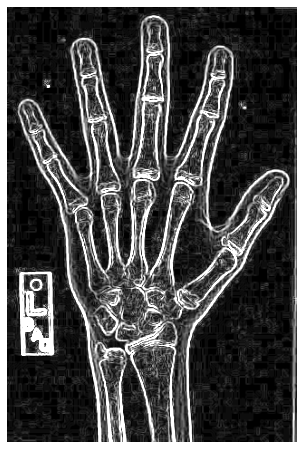

In [124]:
sobel_ax0 = ndi.sobel(im, axis=0)
sobel_ax1 = ndi.sobel(im, axis=1)

# Calculate edge magnitude 
edges = np.sqrt(np.square(sobel_ax0) + np.square(sobel_ax1))

# Plot edge magnitude
plt.imshow(edges, cmap='gray', vmax=75)
format_and_render_plot()